In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:

from mglvq import MGLVQ as MGLVQ # Original Version mit tracking
from mglvq_uneven import MGLVQ as MGLVQ_uneven # Original Version mit tracking & uneven

from vmglvq_dietlind import VMGLVQ as vMGLVQ_dietlind # Original Version Dietlind Fehlermeldung unterdrückt
from vmglvq_tracking_V1 import VMGLVQ as vMGLVQ_V1
from vmglvq_tracking_V2 import VMGLVQ as vMGLVQ_V2 
from vmglvq_uneven_prototype_numbers import VMGLVQ as vMGLVQ_uneven # Angepasste Version mit weight initialization, uneven & tracking


In [3]:
from functions import (
    align_square_matrix_to_df_order,
    align_matrices_to_df,
    visualize_from_distance_and_model,
    plot_training_overview,
)

2025-11-13 09:56:11.818326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 09:56:11.833165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-13 09:56:11.849897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-13 09:56:11.854584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-13 09:56:11.866631: I tensorflow/core/platform/cpu_feature_guar

# read data

## y

In [4]:
import os
print(os.getcwd())

/home/pmlb/data-science/MGLVQ/data/dietlind


In [5]:
import pickle
y_df_060101_original = pd.read_pickle("/home/pmlb/data-science/MGLVQ/data/flags_all_ph3_2024.pkl")[['CustomerCode','060101']]
# --- Laden (bei Bedarf) ---
base = Path("")
base.mkdir(parents=True, exist_ok=True)
fname = base / f"mapping_customer_code.pkl"
with open(fname, "rb") as f:
    mapping = pickle.load(f)

y_df_060101_original["CustomerCode"] = y_df_060101_original["CustomerCode"].map(mapping).fillna("")
y_df_060101_original

ProdHier3Code,CustomerCode,060101
0,C00003,1
1,C00007,1
2,C00008,0
3,C00010,1
4,C00016,0
...,...,...
2037,C01768,0
2038,C01817,0
2039,C01949,0
2040,C02159,0


In [6]:
y_df_0201_original = pd.read_pickle('data/0201.pkl')
y_df_0201_optimized = pd.read_pickle('data/0201_optimized.pkl')

y_df_0601_original = pd.read_pickle('data/0601.pkl')
y_df_0601_optimized = pd.read_pickle('data/0601_optimized.pkl')

y_df_0602_original = pd.read_pickle('data/0602.pkl')
y_df_0602_optimized = pd.read_pickle('data/0602_optimized.pkl')

y_df_0604_original = pd.read_pickle('data/0604.pkl')
y_df_0604_optimized = pd.read_pickle('data/0604_optimized.pkl')

In [7]:
y_df_0201_original

,CustomerCode,0201
0,C00003,1
1,C00004,1
2,C00005,0
3,C00006,0
4,C00007,0
...,...,...
2037,C02408,0
2038,C02409,1
2039,C02410,0
2040,C02411,1


In [8]:
dfs = {
    "y_df_0201_original":  y_df_0201_original,
    "y_df_0201_optimized": y_df_0201_optimized,
    "y_df_0601_original":  y_df_0601_original,
    "y_df_0601_optimized": y_df_0601_optimized,
    "y_df_0602_original":  y_df_0602_original,
    "y_df_0602_optimized": y_df_0602_optimized,
    "y_df_0604_original":  y_df_0604_original,
    "y_df_0604_optimized": y_df_0604_optimized,
}

for name, df in dfs.items():
    print(f"{name}: {len(df)}")

y_df_0201_original: 2042
y_df_0201_optimized: 1832
y_df_0601_original: 2042
y_df_0601_optimized: 1890
y_df_0602_original: 2042
y_df_0602_optimized: 1798
y_df_0604_original: 2042
y_df_0604_optimized: 1855


## matrizes

In [9]:
D_weighted_sub_p = pd.read_pickle('data/D_weighted_sub_p.pkl')
D_naics_sub_p = pd.read_pickle('data/D_naics_sub_p.pkl')
D_hs_sub_p = pd.read_pickle('data/D_hs_sub_p.pkl')
D_am_sub_p =pd.read_pickle('data/D_am_sub_p.pkl')
D_geo_sub_p = pd.read_pickle('data/D_geo_sub_p.pkl')
D_numeric_sub_p = pd.read_pickle('data/D_numeric_sub_p.pkl')

In [10]:
mats = {
    "D_weighted_sub_p": D_weighted_sub_p,
    "D_naics_sub_p":    D_naics_sub_p,
    "D_hs_sub_p":       D_hs_sub_p,
    "D_am_sub_p":       D_am_sub_p,
    "D_geo_sub_p":      D_geo_sub_p,
    "D_numeric_sub_p":  D_numeric_sub_p,
}

for name, D in mats.items():
    print(f"{name}: shape={D.shape}")

D_weighted_sub_p: shape=(2042, 2042)
D_naics_sub_p: shape=(2042, 2042)
D_hs_sub_p: shape=(2042, 2042)
D_am_sub_p: shape=(2042, 2042)
D_geo_sub_p: shape=(2041, 2041)
D_numeric_sub_p: shape=(1451, 1451)


# preparation

## MGLVQ

In [11]:
# test
y_df = y_df_0601_original#optimized
D_sorted = align_square_matrix_to_df_order(D_weighted_sub_p, y_df, id_col="CustomerCode", return_numpy=False)
display(len(y_df))
display(D_sorted.shape)

2042

(2042, 2042)

## vMGLVQ

In [12]:
#test
mats = {
    "D_weighted_sub": D_weighted_sub_p,
    "D_naics_sub":    D_naics_sub_p,
    "D_hs_sub":       D_hs_sub_p,
    "D_am_sub":       D_am_sub_p,
    "D_geo_sub":      D_geo_sub_p,
}

y_df = y_df_0601_original#_optimized


aligned_np, y_df_cut, ordered_ids = align_matrices_to_df(
    mats, y_df, id_col="CustomerCode",
    matrices_as_numpy=True, set_globals=True
)

# Matrizen als Variablen sichern (NumPy-Arrays, weil matrices_as_numpy=True)
D_weighted_sub_p_aligned = aligned_np["D_weighted_sub"]
D_naics_sub_p_aligned    = aligned_np["D_naics_sub"]
D_hs_sub_p_aligned       = aligned_np["D_hs_sub"]
D_am_sub_p_aligned       = aligned_np["D_am_sub"]
D_geo_sub_p_aligned      = aligned_np["D_geo_sub"]


[1] KGN (Schnittmenge über alle Matrizen): 2041 IDs
[2] DF gekürzt auf KGN: 2041 Zeilen | eindeutige IDs in DF-Reihenfolge: 2041
[3] D_weighted_sub_p_aligned -> (2041, 2041) (ndarray)
[3] D_naics_sub_p_aligned -> (2041, 2041) (ndarray)
[3] D_hs_sub_p_aligned -> (2041, 2041) (ndarray)
[3] D_am_sub_p_aligned -> (2041, 2041) (ndarray)
[3] D_geo_sub_p_aligned -> (2041, 2041) (ndarray)
[4] df_cut -> Series mit Name '0601' und Länge 2041


# prediction

## MGLVQ

### Original

In [13]:
y_df = y_df_0601_original
D_sorted = align_square_matrix_to_df_order(D_naics_sub_p, y_df, id_col="CustomerCode", return_numpy=True)
display(len(y_df))
display(D_sorted.shape)

2042

(2042, 2042)

In [17]:
model = MGLVQ(K= 4, T=50, track_path=True)
D = D_sorted
y = np.asarray(y_df['0601'].to_numpy().astype(int))
model.fit(D, y)
display(model.score(D, y))

0.732615083251714

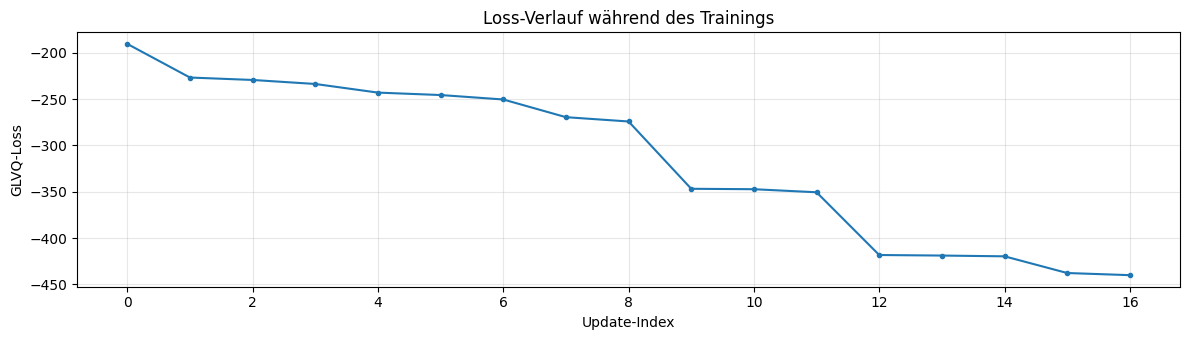

In [18]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

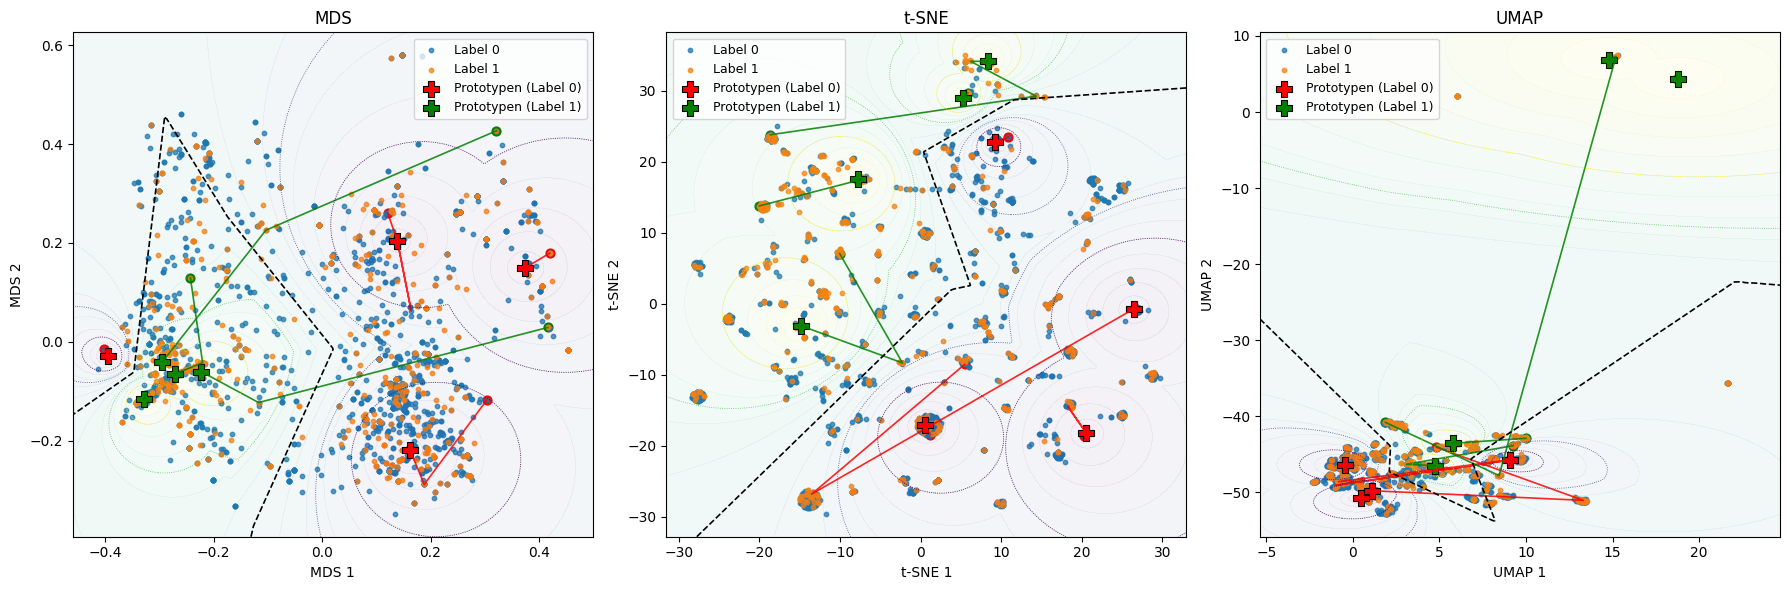

In [19]:
fig, axes, emb = visualize_from_distance_and_model(
    model, D, y,
    # Laden (falls vorhanden), sonst rechnen:
    mds_load_path="embeddings/mds/0601/one_matrix/naics_original.npy",
    tsne_load_path="embeddings/tsne/0601/one_matrix/naics_original.npy",
    umap_load_path="embeddings/umap/0601/one_matrix/naics_original.npy",
    # Beim Rechnen speichern:
    mds_save_path="embeddings/mds/0601/one_matrix/naics_original.npy",
    tsne_save_path="embeddings/tsne/0601/one_matrix/naics_original.npy",
    umap_save_path="embeddings/umap/0601/one_matrix/naics_original.npy",
)

### Uneven

In [20]:
model = MGLVQ_uneven(K={0: 6, 1: 4}, T=50, track_path=True)
D = D_sorted
y = np.asarray(y_df['0601'].to_numpy().astype(int))
model.fit(D, y)
display(model.score(D, y))

0.7443682664054848

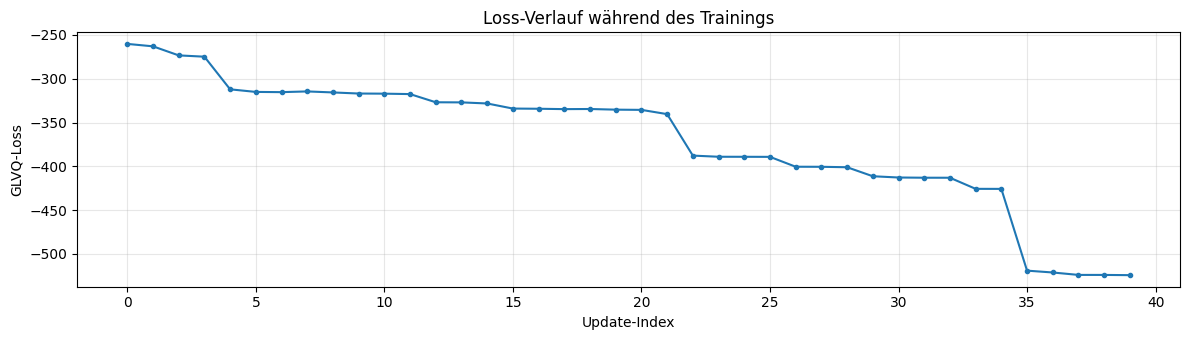

In [21]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

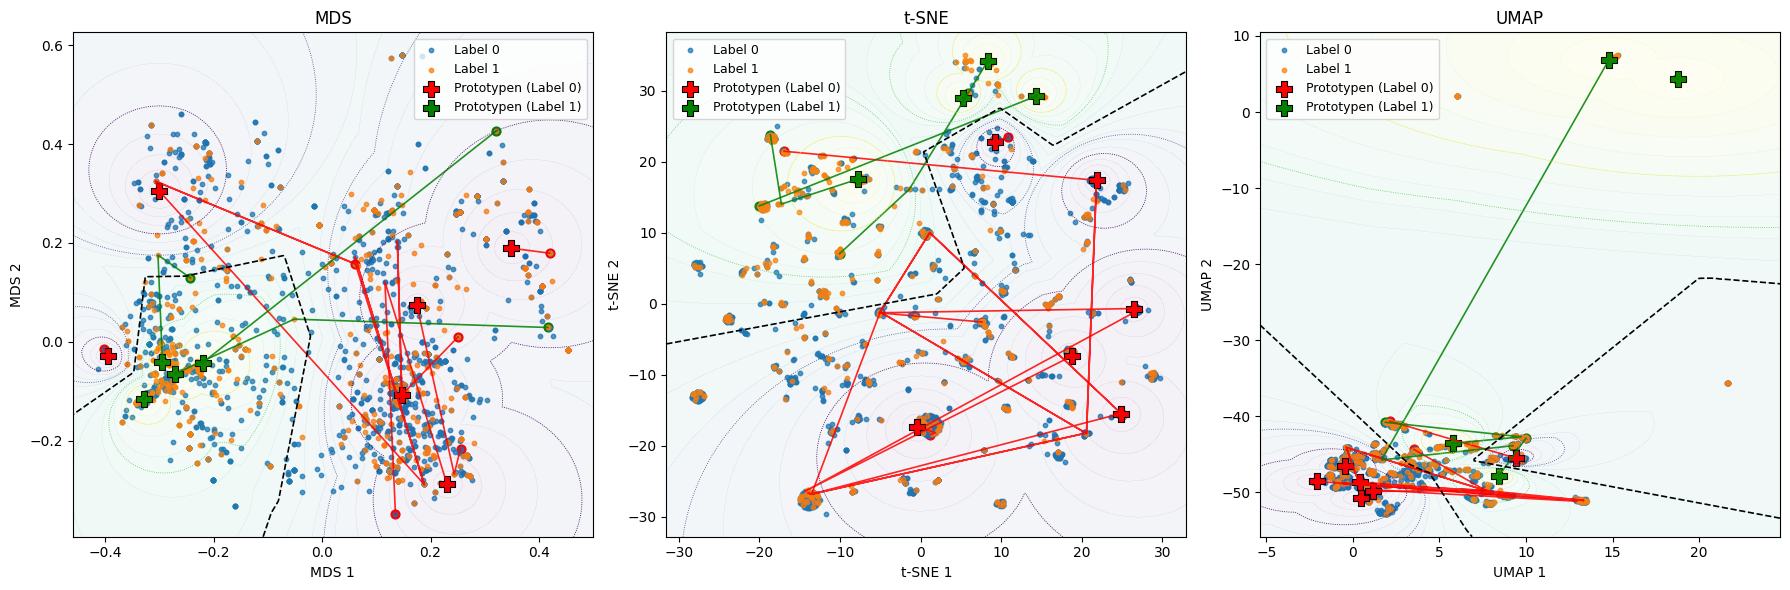

In [22]:
fig, axes, emb = visualize_from_distance_and_model(
    model, D, y,
    # Laden (falls vorhanden), sonst rechnen:
    mds_load_path="embeddings/mds/0601/one_matrix/naics_original.npy",
    tsne_load_path="embeddings/tsne/0601/one_matrix/naics_original.npy",
    umap_load_path="embeddings/umap/0601/one_matrix/naics_original.npy",
    # Beim Rechnen speichern:
    mds_save_path="embeddings/mds/0601/one_matrix/naics_original.npy",
    tsne_save_path="embeddings/tsne/0601/one_matrix/naics_original.npy",
    umap_save_path="embeddings/umap/0601/one_matrix/naics_original.npy",
)

## vMGLVQ

### Dietlind original

In [23]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned)
D_am_scaled    = robust_scale(D_am_sub_p_aligned)
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned)

# 3) DL bauen (vier Sichten)
DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
#DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)


model = vMGLVQ_dietlind(K=3,
                      T=20,
                       )

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
print("Trainings-Accuracy:", model.score(DL, y))

/home/pmlb/miniconda3/lib/python3.10/site-packages/proto_dist_ml/rng.py:152: RuntimeWarning: invalid value encountered in divide
  self._Alpha /= np.expand_dims(np.sum(self._Alpha, axis=1), 1)


[Warnung] Loss-Abweichung: erwartet -1530.557, tatsächlich -1209.325 (rel_err=33.807%)
[Warnung] Loss-Abweichung: erwartet -1501.958, tatsächlich -1620.331 (rel_err=9.788%)
Gelernten Sicht-Gewichte (sum=1): [ 9.97757973e-01 -4.73282665e-18  2.07751697e-03  1.64509688e-04]
Prototyp-Indizes: [ 476 1176  972  510 1113  628]
Trainings-Accuracy: 0.49093581577658013


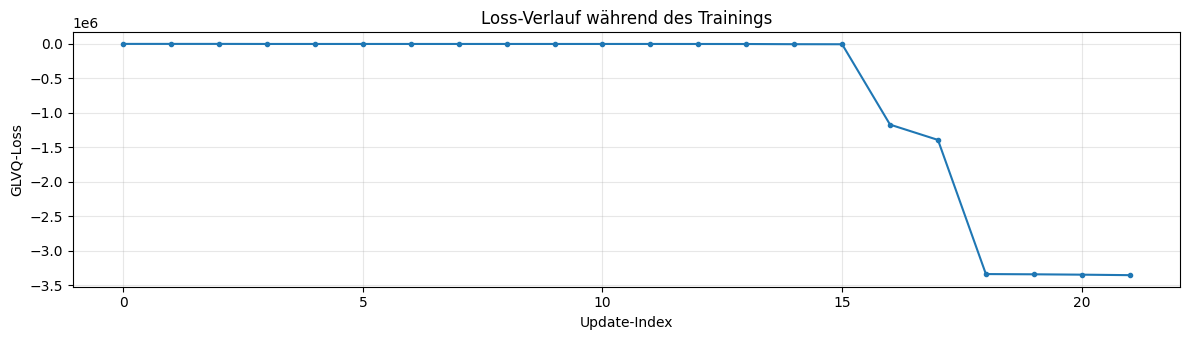

In [25]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

In [ ]:
D = D_weighted_sub_p_aligned
fig, axes, emb = visualize_from_distance_and_model(
    model, D, y,
    # Laden (falls vorhanden), sonst rechnen:
    mds_load_path="embeddings/mds/0601/multi_matrix/naics_original",
    tsne_load_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_load_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
    # Beim Rechnen speichern:
    mds_save_path="embeddings/mds/0601/multi_matrix/naics_original.npy",
    tsne_save_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_save_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
)

### Dietlind & tracking

In [ ]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned)
D_am_scaled    = robust_scale(D_am_sub_p_aligned)
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned)

# 3) DL bauen (vier Sichten)
DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
#DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)


model = vMGLVQ_V1(K=3,
               T=100,
               eta = 0.05,
               track_path=True,     # Prototypen-Verlauf
               track_vweights=True,    # Matrixgewichte-Verlauf
               track_metrics=True      # Loss, dp/dm etc.
)

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
print("Trainings-Accuracy:", model.score(DL, y))

In [ ]:
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

In [ ]:
D = D_weighted_sub_p_aligned
fig, axes, emb = visualize_from_distance_and_model(
    model, D, y,
    # Laden (falls vorhanden), sonst rechnen:
    mds_load_path="embeddings/mds/0601/multi_matrix/naics_original",
    tsne_load_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_load_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
    # Beim Rechnen speichern:
    mds_save_path="embeddings/mds/0601/multi_matrix/naics_original.npy",
    tsne_save_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_save_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
)

### Angepasst

In [ ]:
# 2) Optional: pro Sicht grob auf gleiche Skala bringen (sonst dominiert eine)
def robust_scale(D):
    D = D.astype(np.float32)  # spart RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)

D_naics_scaled = robust_scale(D_naics_sub_p_aligned)
D_hs_scaled    = robust_scale(D_hs_sub_p_aligned )
D_am_scaled    = robust_scale(D_am_sub_p_aligned )
D_geo_scaled   = robust_scale(D_geo_sub_p_aligned )

# 3) DL bauen (vier Sichten)
#DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]
DL = [D_naics_sub_p_aligned, D_hs_sub_p_aligned, D_am_sub_p_aligned, D_geo_sub_p_aligned]

# 4) y in derselben Reihenfolge wie df (Länge m=1525!)
# Beispiel: falls deine Labels in df["y_col"] liegen:
y = np.asarray(y_df_cut.to_numpy().astype(int))
m = len(y)

# 5) Konsistenz-Checks
for k, D in enumerate(DL, start=1):
    assert D.shape == (m, m), f"Sicht {k} hat Shape {D.shape}, erwartet {(m,m)}"
    # falls gewünscht: Diagonale 0
    np.fill_diagonal(D, 0.0)


# 6) Modell trainieren (K = Prototypen pro Klasse; z.B. 5)
K = 3
model = vMGLVQ_V2(K={0: 8, 1: 7},           # Label 0 -> 3 Protos, Label 1 -> 5 Protos
                        T=100,
                        eta=0.1,
                        v_init=[0.3,0.2,0.4,0.1],   # Startgewichte
                        track_path=True,
                        track_vweights=True,
                        track_metrics=True
                    )

model.fit(DL, y)

print("Gelernten Sicht-Gewichte (sum=1):", model._vWeights)  # Länge 4
print("Prototyp-Indizes:", model._w)                         # Länge = K * #Klassen
#print("Trainings-Accuracy:", model.score(DL, y))

# (Optional) Prototypen je Klasse anzeigen
for c in np.unique(y):
    proto_ids = model._w[model._y == c]
    print(f"Klasse {c}: {len(proto_ids)} Prototypen -> Indizes {proto_ids}")
print("Trainings-Accuracy:", model.score(DL, y))
fig = plot_training_overview(model, smooth_v=0, show=False, return_fig=True)

In [ ]:
D = D_weighted_sub_p_aligned
fig, axes, emb = visualize_from_distance_and_model(
    model, D, y,
    # Laden (falls vorhanden), sonst rechnen:
    mds_load_path="embeddings/mds/0601/multi_matrix/naics_original",
    tsne_load_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_load_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
    # Beim Rechnen speichern:
    mds_save_path="embeddings/mds/0601/multi_matrix/naics_original.npy",
    tsne_save_path="embeddings/tsne/0601/multi_matrix/naics_original.npy",
    umap_save_path="embeddings/umap/0601/multi_matrix/naics_original.npy",
)

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.manifold import MDS

# --- Checks ---
def _validate_distance_matrix(D: np.ndarray):
    D = np.asarray(D, dtype=np.float64)
    if D.ndim != 2 or D.shape[0] != D.shape[1]:
        raise ValueError("Distance matrix must be square.")
    np.fill_diagonal(D, 0.0)
    if not np.allclose(D, D.T, atol=1e-8, rtol=1e-8):
        raise ValueError("Distance matrix must be symmetric.")
    if (D < -1e-12).any():
        raise ValueError("Distances must be non-negative.")
    return D

def classical_mds_from_distance(D, n_components=2):
    D = np.asarray(D, dtype=np.float64)
    n = D.shape[0]
    D2 = D ** 2
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D2 @ J
    w, V = np.linalg.eigh(B)
    idx = np.argsort(w)[::-1]
    w = w[idx]; V = V[:, idx]
    L = np.clip(w[:n_components], 0, None)
    Y = V[:, :n_components] * np.sqrt(L)
    return Y

# --- Rechnen ---
def compute_mds_embeddings(matrices, method="precomputed", n_components=2, random_state=42, max_iter=300, eps=1e-3):
    """
    matrices: dict name->D  ODER list/tuple [D1, D2, ...]
    method: 'precomputed' (sklearn MDS mit dissimilarity='precomputed') | 'classical'
    return: dict name->X (n,2)
    """
    if isinstance(matrices, dict):
        items = list(matrices.items())
    else:
        items = [(f"D{i+1}", D) for i, D in enumerate(matrices)]

    out = {}
    for name, D in items:
        D = _validate_distance_matrix(D)

        if method == "classical":
            X = classical_mds_from_distance(D, n_components=n_components)
        elif method == "precomputed":
            X = MDS(
                n_components=n_components,
                dissimilarity="precomputed",
                random_state=random_state,
                max_iter=max_iter,
                eps=eps,
            ).fit_transform(D)
        else:
            raise ValueError("method muss 'precomputed' oder 'classical' sein.")

        out[name] = X
    return out

# --- Speichern ---
def save_embeddings(embeds: dict, out_dir="embeddings/mds", fmt="npy", ids: dict | None = None, overwrite=False):
    """
    embeds: dict name->X (n,2)
    fmt: 'npy' | 'npz' | 'csv'
    ids: optional dict name->IDs (gleiche Reihenfolge wie X)
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for name, X in embeds.items():
        X = np.asarray(X, float)
        target = Path(out_dir) / f"{name}.{fmt}"
        if target.exists() and not overwrite:
            continue

        if fmt == "npy":
            np.save(target, X)
        elif fmt == "npz":
            if ids and name in ids and ids[name] is not None:
                np.savez_compressed(target, X=X, ids=np.asarray(ids[name], dtype=object))
            else:
                np.savez_compressed(target, X=X)
        elif fmt == "csv":
            if ids and name in ids and ids[name] is not None:
                ids_arr = np.asarray(ids[name], dtype=object).reshape(-1, 1)
                arr = np.concatenate([ids_arr, X], axis=1)
                header = "id,x1,x2"
                np.savetxt(target, arr, fmt="%s", delimiter=",", header=header, comments="")
            else:
                header = "x1,x2"
                np.savetxt(target, X, fmt="%.10g", delimiter=",", header=header, comments="")
        else:
            raise ValueError("fmt muss 'npy', 'npz' oder 'csv' sein.")


In [ ]:
# test
y_df = y_df_0601_optimized
D_sorted = align_square_matrix_to_df_order(D_weighted_sub_p, y_df, id_col="CustomerCode", return_numpy=False)
display(len(y_df))
display(D_sorted.shape)


In [ ]:
D_weighted_sub_p_aligned.shape

In [ ]:


# Angenommen D1..D5 sind deine 5 Distanzmatrizen
from pathlib import Path
import os, json, time


# Zielordner festlegen
out_dir = "embeddings/0601/one_matrix/"

mats = {"weighted": D_sorted}

# 1) Rechnen
embeds = compute_mds_embeddings(
    mats,
    method="precomputed",   # <— genau das wolltest du
    n_components=2,
    random_state=42
)

# 2a) Arrays als .npy sichern (pro Matrix eine Datei: A.npy, B.npy, ...)
save_embeddings(embeds, out_dir=out_dir, fmt="npy", overwrite=True)